In [87]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import matplotlib.pyplot as plt
import os

In [97]:
#파일 경로 설정
file_path = 'WISDM_ar_v1.1_raw.txt'

# --- 1. 파일 불러오기 및 데이터 전처리 ---
print("데이터 전처리 시작...")
try:
    # 파일을 한 줄씩 읽고 파싱하여 ParserError를 방지
    parsed_data = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip().replace(';', '')
            if not line:
                continue
            parts = line.split(',')
            
            # 예상치 못한 필드가 있는 경우 (예: "Jogging,49105962326000")를 처리
            if len(parts) > 6:
                activity = parts[1] + ',' + parts[2]
                rest = parts[3:]
                parts = [parts[0], activity] + rest

            if len(parts) == 6:
                parsed_data.append(parts)

    df = pd.DataFrame(parsed_data, columns=['user', 'activity', 'timestamp', 'x-accel', 'y-accel', 'z-accel'])

    # 데이터 타입 변환
    df['user'] = pd.to_numeric(df['user'], errors='coerce')
    df['timestamp'] = pd.to_numeric(df['timestamp'], errors='coerce')
    df['x-accel'] = pd.to_numeric(df['x-accel'], errors='coerce')
    df['y-accel'] = pd.to_numeric(df['y-accel'], errors='coerce')
    df['z-accel'] = pd.to_numeric(df['z-accel'], errors='coerce')
    
    # 불필요한 공백 제거
    df['activity'] = df['activity'].str.strip()

    # NaN 값이 있는 행 제거
    df.dropna(inplace=True)

    print("데이터 전처리 완료. 데이터 정보:")
    df.info()
    print("\n전처리된 데이터 상위 5개 행:")
    print(df.head())

except FileNotFoundError:
    print(f"오류: {file_path} 파일을 찾을 수 없습니다. 파일이 현재 스크립트와 동일한 디렉터리에 있는지 확인해주세요.")
    exit()


데이터 전처리 시작...
데이터 전처리 완료. 데이터 정보:
<class 'pandas.core.frame.DataFrame'>
Index: 1086465 entries, 0 to 1098198
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1086465 non-null  int64  
 1   activity   1086465 non-null  object 
 2   timestamp  1086465 non-null  float64
 3   x-accel    1086465 non-null  float64
 4   y-accel    1086465 non-null  float64
 5   z-accel    1086465 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 58.0+ MB

전처리된 데이터 상위 5개 행:
   user activity        timestamp  x-accel  y-accel  z-accel
0    33  Jogging 49105962326000.0     -0.7     12.7      0.5
1    33  Jogging 49106062271000.0      5.0     11.3      1.0
2    33  Jogging 49106112167000.0      4.9     10.9     -0.1
3    33  Jogging 49106222305000.0     -0.6     18.5      3.0
4    33  Jogging 49106332290000.0     -1.2     12.1      7.2


In [101]:
df

,user,activity,timestamp,x-accel,y-accel,z-accel
0,33,Jogging,49105962326000.0,-0.7,12.7,0.5
1,33,Jogging,49106062271000.0,5.0,11.3,1.0
2,33,Jogging,49106112167000.0,4.9,10.9,-0.1
3,33,Jogging,49106222305000.0,-0.6,18.5,3.0
4,33,Jogging,49106332290000.0,-1.2,12.1,7.2
...,...,...,...,...,...,...
1098194,19,Sitting,131623331483000.0,9.0,-1.6,1.7
1098195,19,Sitting,131623371431000.0,9.0,-1.5,1.7
1098196,19,Sitting,131623411592000.0,9.1,-1.4,1.7
1098197,19,Sitting,131623491487000.0,9.0,-1.5,1.7


In [103]:
# --- 2. 특징과 라벨 ---
label_encoder = LabelEncoder()
df['activity_encoded'] = label_encoder.fit_transform(df['activity'])
FEATURES = ['x-accel', 'y-accel', 'z-accel']
LABELS = ['activity_encoded']
print("\n인코딩된 활동 라벨:")
print(label_encoder.classes_)


인코딩된 활동 라벨:
['Downstairs' 'Jogging' 'Sitting' 'Standing' 'Upstairs' 'Walking']


In [105]:

# --- 3. 슬라이딩 윈도우 함수 ---
def create_sliding_windows(data, window_size, step_size):
    X, y = [], []
    num_data_points = data.shape[0]

    for i in range(0, num_data_points - window_size, step_size):
        window = data.iloc[i:i + window_size]
        features = window[FEATURES].values
        labels = window[LABELS].values
        most_common_label = Counter(labels.flatten()).most_common(1)[0][0]
        X.append(features)
        y.append(most_common_label)
        
    return np.array(X), np.array(y)

WINDOW_SIZE = 50
STEP_SIZE = 25
X, y = create_sliding_windows(df, WINDOW_SIZE, STEP_SIZE)
print("\n슬라이딩 윈도우 적용 완료. 특징(X) 및 라벨(y) 형태:")
print(f"X.shape: {X.shape}")
print(f"y.shape: {y.shape}")



슬라이딩 윈도우 적용 완료. 특징(X) 및 라벨(y) 형태:
X.shape: (43457, 50, 3)
y.shape: (43457,)


In [106]:
# --- 4. 학습/테스트 데이터 분리 ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("\n학습/테스트 데이터 분리 완료.")
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")



학습/테스트 데이터 분리 완료.
X_train.shape: (34765, 50, 3), y_train.shape: (34765,)
X_test.shape: (8692, 50, 3), y_test.shape: (8692,)


In [111]:
# --- 5. 모델 구성 ---
def build_lstm_model(input_shape, num_classes):
    model = keras.Sequential([
        keras.layers.LSTM(units=128, input_shape=input_shape, return_sequences=True),
        keras.layers.Dropout(0.2),
        keras.layers.LSTM(units=64),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(units=num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

num_classes = len(label_encoder.classes_)
lstm_model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]),
                               num_classes=num_classes)
print("\n모델 요약:")
lstm_model.summary()



모델 요약:


C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 50, 128)             │          67,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 117,382 (458.52 KB)

 Trainable params: 117,382 (458.52 KB)

 Non-trainable params: 0 (0.00 B)

In [113]:
# --- 6. 모델 학습 ---
EPOCHS = 20
BATCH_SIZE = 64
history = lstm_model.fit(X_train, y_train,
                         epochs=EPOCHS,
                         batch_size=BATCH_SIZE,
                         validation_data=(X_test, y_test),
                         verbose=1)

Epoch 1/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 48s 81ms/step - accuracy: 0.7366 - loss: 0.7634 - val_accuracy: 0.8698 - val_loss: 0.3665
Epoch 2/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 45s 84ms/step - accuracy: 0.8856 - loss: 0.3242 - val_accuracy: 0.9245 - val_loss: 0.2173
Epoch 3/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 43s 78ms/step - accuracy: 0.9368 - loss: 0.1886 - val_accuracy: 0.9600 - val_loss: 0.1208
Epoch 4/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 37s 68ms/step - accuracy: 0.9569 - loss: 0.1307 - val_accuracy: 0.9668 - val_loss: 0.1116
Epoch 5/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 34s 62ms/step - accuracy: 0.9665 - loss: 0.1065 - val_accuracy: 0.9719 - val_loss: 0.0917
Epoch 6/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 33s 62ms/step - accuracy: 0.9757 - loss: 0.0799 - val_accuracy: 0.9739 - val_loss: 0.0868
Epoch 7/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 36s 67ms/step - accuracy: 0.9807 - loss: 0.0655 - val_accuracy: 0.9697 - val_loss: 0.0966
Epoch 8/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 38s 69ms/step - accuracy: 0.9825 - loss: 0.0603 - 


--- 모델 평가 결과 ---
테스트 손실 (Test Loss): 0.0721
테스트 정확도 (Test Accuracy): 0.9799


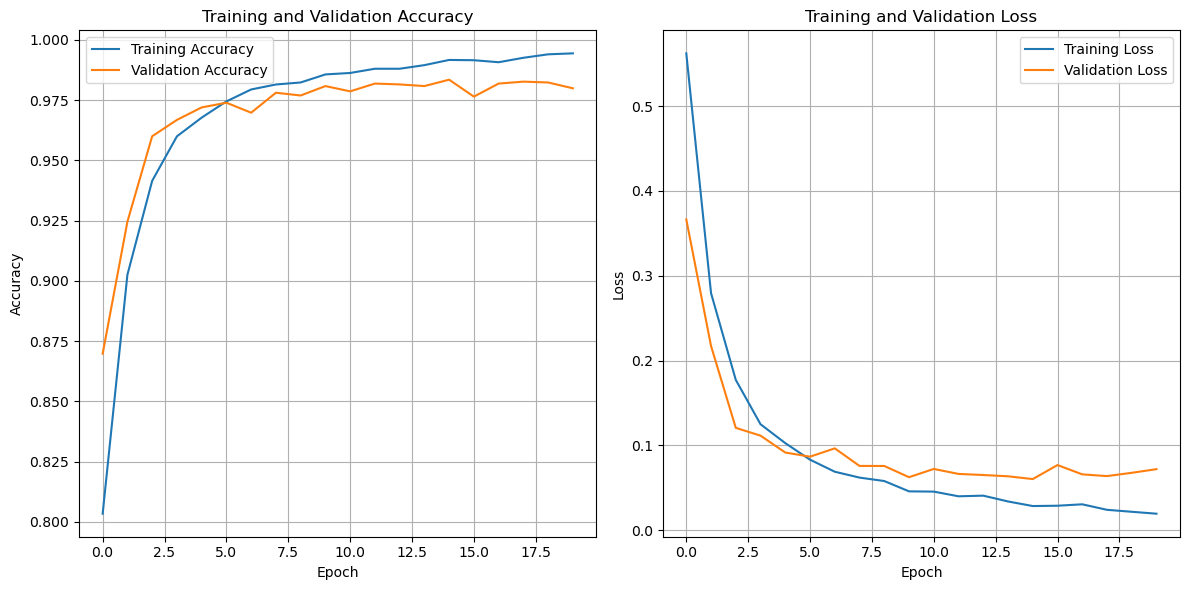

In [115]:

# --- 7. 평가 및 시각화 ---
print("\n--- 모델 평가 결과 ---")
loss, accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"테스트 손실 (Test Loss): {loss:.4f}")
print(f"테스트 정확도 (Test Accuracy): {accuracy:.4f}")

# 정확도 및 손실 시각화
plt.figure(figsize=(12, 6))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()